In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

## Use basic probability to identify anomalous request methods. You will want to make sure the text is normalized in order to reduce the noise.

### Clean up

In [2]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8] # specifiy which columnsto use from the csv
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [3]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [4]:
# begin cleaning up the timestanmp by removing the brackets and extraneous tail

# replace all of the (,\,[,|,\,+,0000,\,],) with nothing basically just remove it
df.timestamp = df.timestamp.str.replace(r'(\[|\+0000\])', '', regex=True)

# replace ':' with a space for just the first column not all of them
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 

# set the index
df = df.set_index('timestamp')

In [5]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [6]:
# clean up string sin columns with extra quotes
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

# simplify and clean up request method by removing page data
df['request_method'] = df.request_method.str.replace(r'\?page=[0-9]+', '', regex=True)

df.sample()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-17 01:52:06,173.173.113.51,GET /api/v1/sales HTTP/1.1,200,501929,NaN,python-requests/2.21.0


In [7]:
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [8]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246


In [9]:
df.describe()

,status,size,size_mb
count,13978.000000,1.397800e+04,13978.000000
mean,200.356703,4.500019e+05,0.429155
std,10.182001,1.614915e+05,0.154010
min,200.000000,0.000000e+00,0.000000
25%,200.000000,5.006370e+05,0.477445
50%,200.000000,5.101380e+05,0.486506
75%,200.000000,5.112910e+05,0.487605
max,499.000000,2.056327e+06,1.961066


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13978 entries, 2019-04-16 19:34:42 to 2019-04-19 19:42:41
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ip              13978 non-null  object 
 1   request_method  13978 non-null  object 
 2   status          13978 non-null  int64  
 3   size            13978 non-null  int64  
 4   destination     25 non-null     object 
 5   request_agent   13978 non-null  object 
 6   size_mb         13978 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 873.6+ KB


___

## Get started

In [11]:
# get the counts of status's in the dataset
rm_df = pd.DataFrame(df.request_method.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'rm_count'})

rm_df.head()

,request_method,rm_count
0,GET /api/v1/sales HTTP/1.1,12403
1,GET /api/v1/items HTTP/1.1,1065
2,GET /api/v1/stores HTTP/1.1,229
3,GET / HTTP/1.1,107
4,GET /documentation HTTP/1.1,100


In [12]:
rm_df.value_counts()

request_method                                rm_count
GET /favicon.ico HTTP/1.1                     26          1
GET /documentation HTTP/1.1                   100         1
GET /api/V1/HiZach! HTTP/1.1                  1           1
GET /api/v1 HTTP/1.1                          1           1
GET /api/v1/ HTTP/1.1                         4           1
GET /api/v1//api/v1/items HTTP/1.1            11          1
GET /api/v1//api/v1/items/next_page HTTP/1.1  1           1
GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1        1           1
GET /api/v1/helloclass! HTTP/1.1              1           1
GET /api/v1/items HTTP/1.1                    1065        1
GET /api/v1/items&page=0 HTTP/1.1             1           1
GET /api/v1/items/HTTP/1.1                    1           1
GET /api/v1/items/api/v1/items HTTP/1.1       7           1
GET /api/v1/items/next_page HTTP/1.1          5           1
GET /api/v1/itemsitems HTTP/1.1               3           1
GET /api/v1/sales HTTP/1.1                   

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '7'),
  Text(6, 0, '11'),
  Text(7, 0, '26'),
  Text(8, 0, '100'),
  Text(9, 0, '107'),
  Text(10, 0, '229'),
  Text(11, 0, '1065'),
  Text(12, 0, '12403')])

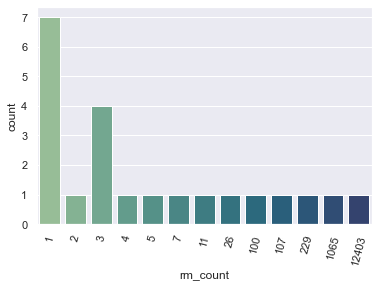

In [13]:
sns.set(style="darkgrid")
sns.countplot(rm_df.rm_count, palette='crest')
plt.xticks(rotation=75)

In [14]:
rm_df.shape

(22, 2)

In [15]:
# get the probability of the ip in the dataset
rm_prob = pd.DataFrame(df.request_method.value_counts(dropna=False)/df.ip.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'rm_prob'})

rm_prob.head()

,request_method,rm_prob
0,GET /api/v1/sales HTTP/1.1,0.887323
1,GET /api/v1/items HTTP/1.1,0.076191
2,GET /api/v1/stores HTTP/1.1,0.016383
3,GET / HTTP/1.1,0.007655
4,GET /documentation HTTP/1.1,0.007154


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 [Text(0, 0, '7.154099298898269e-05'),
  Text(1, 0, '0.00014308198597796538'),
  Text(2, 0, '0.00021462297896694807'),
  Text(3, 0, '0.00028616397195593076'),
  Text(4, 0, '0.00035770496494491345'),
  Text(5, 0, '0.0005007869509228788'),
  Text(6, 0, '0.0007869509228788095'),
  Text(7, 0, '0.0018600658177135498'),
  Text(8, 0, '0.007154099298898269'),
  Text(9, 0, '0.007654886249821148'),
  Text(10, 0, '0.016382887394477037'),
  Text(11, 0, '0.07619115753326657'),
  Text(12, 0, '0.8873229360423522')])

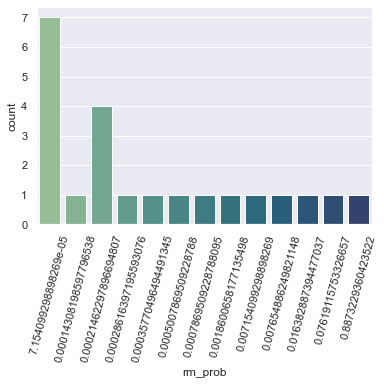

In [16]:
sns.set(style="darkgrid")
sns.countplot(rm_prob.rm_prob, palette='crest')
plt.xticks(rotation=75)

In [17]:
rm_prob.shape

(22, 2)

In [18]:
# merer rm_count and rm_prob into 1 pd df
rm_df = rm_df.merge(rm_prob)
rm_df.head()

,request_method,rm_count,rm_prob
0,GET /api/v1/sales HTTP/1.1,12403,0.887323
1,GET /api/v1/items HTTP/1.1,1065,0.076191
2,GET /api/v1/stores HTTP/1.1,229,0.016383
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

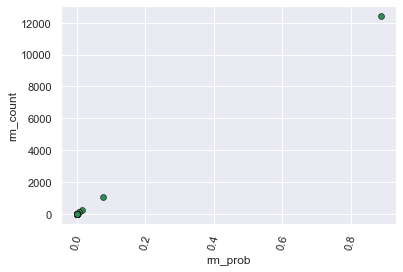

In [19]:
sns.set(style="darkgrid")
sns.scatterplot(x=rm_df.rm_prob, y=rm_df.rm_count, color='seagreen', ec='black')
plt.xticks(rotation=75)

In [20]:
rm_df.shape

(22, 3)

In [21]:
# see those where rate < 2% 
rm_df[rm_df.rm_prob < .02]
# where is probability exceptionaly low?
    # 18 out of 22 are below 1%

,request_method,rm_count,rm_prob
2,GET /api/v1/stores HTTP/1.1,229,0.016383
3,GET / HTTP/1.1,107,0.007655
4,GET /documentation HTTP/1.1,100,0.007154
5,GET /favicon.ico HTTP/1.1,26,0.001860
6,GET /api/v1//api/v1/items HTTP/1.1,11,0.000787
7,GET /api/v1/items/api/v1/items HTTP/1.1,7,0.000501
8,GET /api/v1/items/next_page HTTP/1.1,5,0.000358
9,GET /api/v1/ HTTP/1.1,4,0.000286
10,GET /api/v1/store HTTP/1.1,3,0.000215
11,GET /api/v1/itemsitems HTTP/1.1,3,0.000215


In [22]:
# see those where rate > 2% 
rm_df[rm_df.rm_prob > .02]
# where is probability exceptionaly low?
    # 2 out of 22 are above 2%

,request_method,rm_count,rm_prob
0,GET /api/v1/sales HTTP/1.1,12403,0.887323
1,GET /api/v1/items HTTP/1.1,1065,0.076191


In [23]:
len(rm_df)

22

No handles with labels found to put in legend.
No handles with labels found to put in legend.


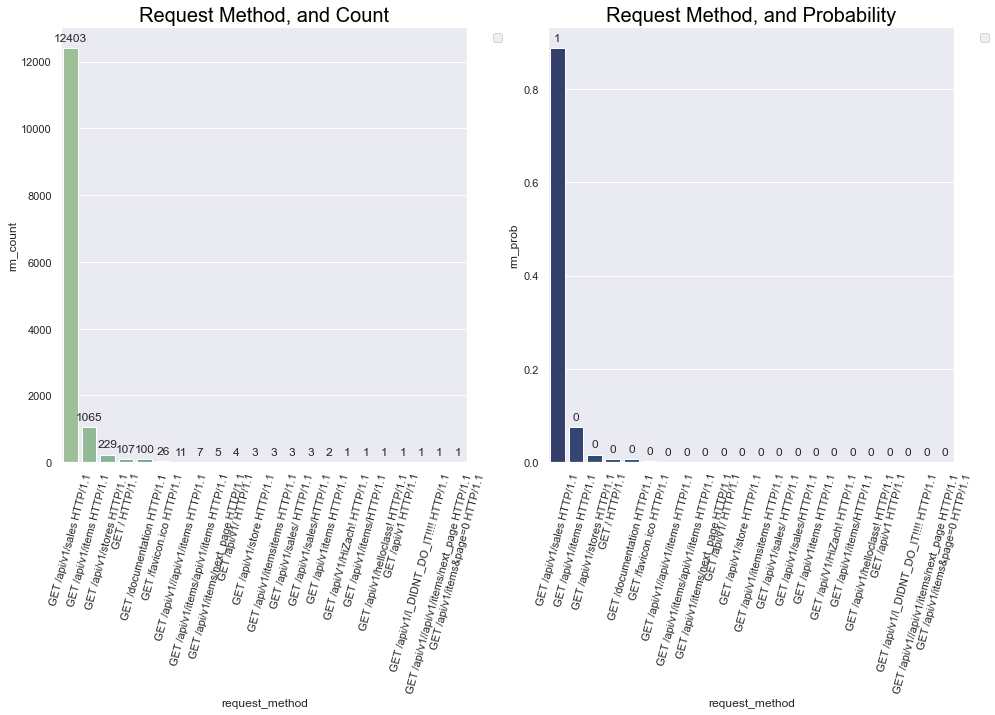

In [24]:
plt.subplots(1, 2, figsize=(16,8), sharey=True)
sns.set(style="darkgrid")

plt.subplot(1,2,1)
plt.title("Request Method, and Count", size=20, color='black')
splot = sns.barplot(data=rm_df, x = 'request_method', y = 'rm_count', 
                    ci = None, palette='crest')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation=75)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    
plt.subplot(1,2,2)
plt.title("Request Method, and Probability", size=20, color='black')
splot = sns.barplot(data=rm_df, x = 'request_method', y = 'rm_prob', 
                    ci = None, palette='crest_r')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation=75)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')


### Baseline

# create train set
train = df.loc['2019-04-16 19:34:42':'2019-04-17 12:55:14']

In [25]:
train_size = .80
n = df.shape[0]
test_start_index = round(train_size * n)
train = df[:test_start_index]

In [26]:
train.size/df.size

0.7999713836028044

In [27]:
train = train[['ip','request_method','status','size','destination','request_agent','size_mb']]

In [28]:
df.shape

(13978, 7)

In [29]:
train.shape

(11182, 7)

### Compute probabilities based on train sample:

In [30]:
rm_df = pd.DataFrame(train.request_method.value_counts(dropna=False)/train.request_method.count()).reset_index().\
                rename(index=str, columns={'index': 'request_method', 'request_method': 'rm_proba'})

In [31]:
rm_df.head()

,request_method,rm_proba
0,GET /api/v1/sales HTTP/1.1,0.899392
1,GET /api/v1/items HTTP/1.1,0.063942
2,GET /api/v1/stores HTTP/1.1,0.014040
3,GET / HTTP/1.1,0.008675
4,GET /documentation HTTP/1.1,0.008317


### Merge probabilities with all data (train + new data):

In [32]:
df = df.reset_index().merge(rm_df, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')
df.rm_proba.value_counts()

0.899392    12403
0.063942     1065
0.014040      229
0.008675      107
0.008317      100
0.001967       26
0.000447       12
0.000984       11
0.000268        9
0.000089        8
0.000358        4
0.000000        4
Name: rm_proba, dtype: int64

In [33]:
df[df['rm_proba'] == 0]

,ip,request_method,status,size,destination,request_agent,size_mb,rm_proba
timestamp,,,,,,,,
2019-04-21 10:02:41,95.31.18.119,GET /api/v1/items/HTTP/1.1,200,1153005,0,python-requests/2.21.0,1.099591,0.0
2019-04-17 19:36:41,95.31.16.121,GET /api/v1/sales/HTTP/1.1,301,1005,0,python-requests/2.21.0,0.000958,0.0
2019-04-18 19:42:41,97.105.15.120,GET /api/v1/sales/HTTP/1.1,301,2560,0,python-requests/2.21.0,0.002441,0.0
2019-04-19 19:42:41,97.105.19.58,GET /api/v1/sales/HTTP/1.1,200,2056327,0,python-requests/2.21.0,1.961066,0.0


### Conditional Probabilities: Probabilities using 2 discrete variables

In [34]:
rm_probs = train.groupby('request_method').size().div(len(df))

status_given_rm = pd.DataFrame(train.groupby(['request_method', 'status']).\
                               size().div(len(train)).\
                               div(rm_probs, 
                                   axis=0, 
                                   level='request_method').\
                               reset_index().\
                               rename(index=str, 
                                      columns={0: 'proba_status_given_rm'})
                              )

In [35]:
status_given_rm

,request_method,status,proba_status_given_rm
0,GET / HTTP/1.1,200,1.250045
1,GET /api/V1/HiZach! HTTP/1.1,200,1.250045
2,GET /api/v1 HTTP/1.1,200,1.250045
3,GET /api/v1/ HTTP/1.1,200,1.250045
4,GET /api/v1//api/v1/items HTTP/1.1,200,1.250045
5,GET /api/v1//api/v1/items/next_page HTTP/1.1,200,1.250045
6,GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1,200,1.250045
7,GET /api/v1/helloclass! HTTP/1.1,200,1.250045
8,GET /api/v1/items HTTP/1.1,200,1.243051
9,GET /api/v1/items HTTP/1.1,499,0.006993


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

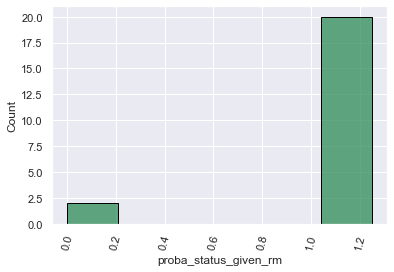

In [36]:
sns.set(style="darkgrid")
sns.histplot(status_given_rm.proba_status_given_rm, color='seagreen', ec='black')
plt.xticks(rotation=75)

In [37]:
rm_status_count = pd.DataFrame(train.groupby(['request_method'])['status'].\
                                count().reset_index().\
                                rename(index=str, 
                                       columns={'status': 'rm_status_count'}))


rm_status = status_given_rm.merge(rm_status_count)

In [38]:
rm_status

,request_method,status,proba_status_given_rm,rm_status_count
0,GET / HTTP/1.1,200,1.250045,97
1,GET /api/V1/HiZach! HTTP/1.1,200,1.250045,1
2,GET /api/v1 HTTP/1.1,200,1.250045,1
3,GET /api/v1/ HTTP/1.1,200,1.250045,4
4,GET /api/v1//api/v1/items HTTP/1.1,200,1.250045,11
5,GET /api/v1//api/v1/items/next_page HTTP/1.1,200,1.250045,1
6,GET /api/v1/I_DIDNT_DO_IT!!!! HTTP/1.1,200,1.250045,1
7,GET /api/v1/helloclass! HTTP/1.1,200,1.250045,1
8,GET /api/v1/items HTTP/1.1,200,1.243051,715
9,GET /api/v1/items HTTP/1.1,499,0.006993,715


(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000., 12000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

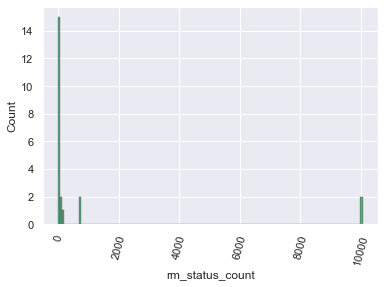

In [39]:
sns.set(style="darkgrid")
sns.histplot(rm_status.rm_status_count, color='seagreen', ec='black')
plt.xticks(rotation=75)

### Add these probabilities to original events to detect anomalous events:

In [40]:
df = df.reset_index().merge(rm_status, on=['request_method'], how='left').fillna(value=0).set_index('timestamp')

In [41]:
df.head()

,ip,request_method,status_x,size,destination,request_agent,size_mb,rm_proba,status_y,proba_status_given_rm,rm_status_count
timestamp,,,,,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.899392,200.0,1.248802,10057.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,512495,0,python-requests/2.21.0,0.488753,0.899392,499.0,0.001243,10057.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.063942,200.0,1.243051,715.0
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,0,python-requests/2.21.0,0.003396,0.063942,499.0,0.006993,715.0
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales HTTP/1.1,200,510103,0,python-requests/2.21.0,0.486472,0.899392,200.0,1.248802,10057.0


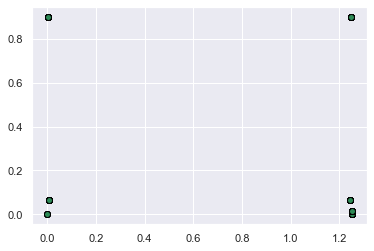

In [42]:
sns.set(style="darkgrid")
plt.scatter(df.proba_status_given_rm, df.rm_proba, color='seagreen', ec='black')

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, '0.0'),
  Text(1, 0, '0.0012429598436115004'),
  Text(2, 0, '0.006993257145287193'),
  Text(3, 0, '1.2430514575747988'),
  Text(4, 0, '1.2488017548764745'),
  Text(5, 0, '1.2500447147200857'),
  Text(6, 0, '1.250044714720086')])

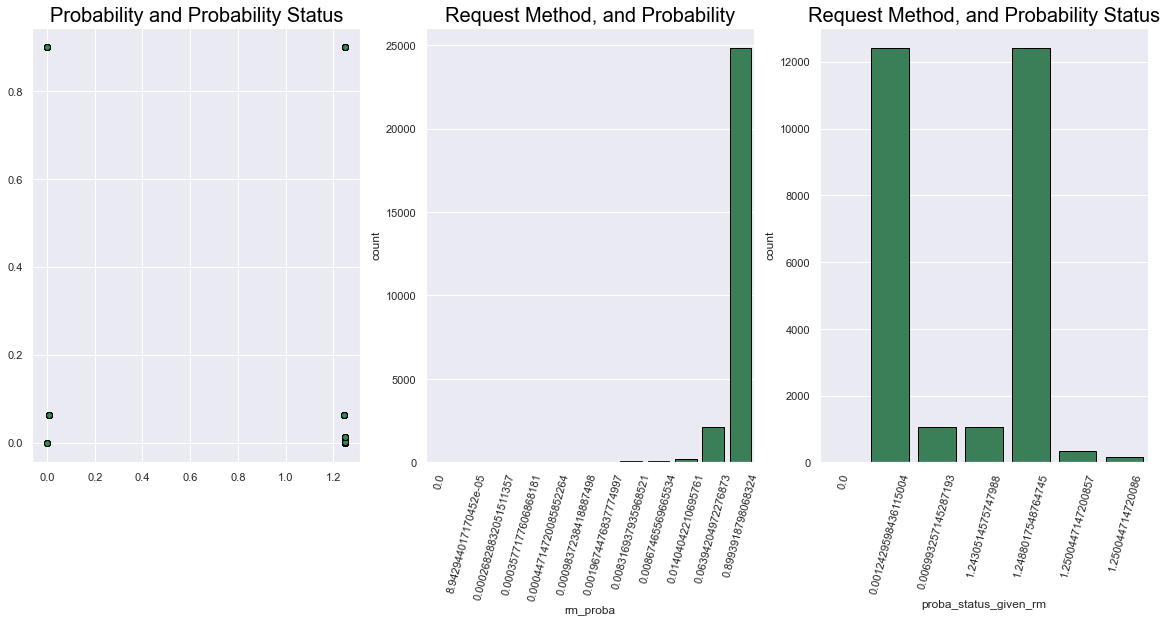

In [43]:
plt.subplots(1, 3, figsize=(20,8), sharey=True)
sns.set(style="darkgrid")

plt.subplot(1,3,1)
plt.title("Probability and Probability Status", size=20, color='black')
plt.scatter(df.proba_status_given_rm, df.rm_proba, color='seagreen', ec='black')
    
plt.subplot(1,3,2)
plt.title("Request Method, and Probability", size=20, color='black')
sns.countplot(df.rm_proba, color='seagreen', ec='black')
plt.xticks(rotation=75)

plt.subplot(1,3,3)
plt.title("Request Method, and Probability Status", size=20, color='black')
sns.countplot(df.proba_status_given_rm, color='seagreen', ec='black')
plt.xticks(rotation=75)